<a href="https://colab.research.google.com/github/seungmindavid/Weight-Loss-Prediction-Using-GNN/blob/main/Boohee_Weight_Loss_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import math
import torch
from torch_geometric.datasets import Planetoid
import torch.nn.functional as Torch_F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import SGConv
import statistics
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import networkx as nx
from torch_geometric.utils import to_networkx
from torch_geometric.utils import from_networkx
from datetime import datetime, date
import copy
from sklearn.preprocessing import StandardScaler


In [ ]:
def age(born):
    today = date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

In [ ]:
# since we are predicting users in BOOHEE will loose weight or not, this is a classification problem.
# And we know users are

# So, there are 3 social network matrix (Following, Mention, Comment)
# We need to create 1 user feature matrix
# Then, by using Graph Convolutional Network algorithm, or GAT (Graph Attention Network)
# we can create embedding space for those 3 matrixes

# After we merge 3 embedded matrixes into 1 network matrix we can apply the machine learning ML Something like logistic regression,

# Following
following = pd.read_csv("./WeightLoss/network/friend_consolidated.csv")

# Comment
comment = pd.read_csv("./WeightLoss/network/comment_rela.csv")
comment = comment[comment['who-comment'].isnull() == False]

# Mention
mention = pd.read_csv("./WeightLoss/network/mention_rela.csv")
mention = mention[mention['who-mention'].isnull() == False]

# Post (How active is user)
post = pd.read_csv("./WeightLoss/post_consolidated.csv")
# Number of post user 121 posted : post_consolidated[post_consolidated['user_id'] == 121]

# User feature matrix: Users_consolidated
users_consolidated = pd.read_csv("./WeightLoss/users_consolidated.csv")


In [ ]:
# How active user is (# of posts)
# should consider NaN value -> 0
post = post['user_id'].value_counts().rename_axis('user_id').reset_index(name='posting')
users_consolidated = users_consolidated.set_index('id').join(post.set_index('user_id'))
users_consolidated["posting"] = users_consolidated["posting"].fillna(0)

del post # It's necessary to keep RAM Memory for later
print('done post')
# Number of Followers and Following
follower_num = following['user_id'].value_counts().rename_axis('user_id').reset_index(name='follower_number')
following_num = following['follower_id'].value_counts().rename_axis('follower_id').reset_index(name='following_number')

users_consolidated = users_consolidated.join(follower_num.set_index('user_id'))
users_consolidated = users_consolidated.join(following_num.set_index('follower_id'))

users_consolidated["follower_number"] = users_consolidated["follower_number"].fillna(0)
users_consolidated["following_number"] = users_consolidated["following_number"].fillna(0)

del follower_num # It's necessary to keep RAM Memory for later
del following_num # It's necessary to keep RAM Memory for later

print('done following')
# Number of Comments and received comments
who_comment = comment['who-comment'].value_counts().rename_axis('who-comment').reset_index(name='comment_giving')
comment_who = comment[' comment-who'].value_counts().rename_axis('comment-who').reset_index(name='received_comment')

users_consolidated = users_consolidated.join(who_comment.set_index('who-comment'))
users_consolidated = users_consolidated.join(comment_who.set_index('comment-who'))


users_consolidated["comment_giving"] = users_consolidated["comment_giving"].fillna(0)
users_consolidated["received_comment"] = users_consolidated["received_comment"].fillna(0)

del who_comment # It's necessary to keep RAM Memory for later
del comment_who # It's necessary to keep RAM Memory for later
print('done commenting')

#Number of Mentions and received mentions
who_mention = mention['who-mention'].value_counts().rename_axis('who-mention').reset_index(name='mentioning')
mention_who = mention['mention-who'].value_counts().rename_axis('mention-who').reset_index(name='received_mention')
users_consolidated = users_consolidated.join(who_mention.set_index('who-mention'))
users_consolidated = users_consolidated.join(mention_who.set_index('mention-who'))


users_consolidated["mentioning"] = users_consolidated["mentioning"].fillna(0)
users_consolidated["received_mention"] = users_consolidated["received_mention"].fillna(0)

del who_mention # It's necessary to keep RAM Memory for later
del mention_who # It's necessary to keep RAM Memory for later

print('done mention')
# convert to proper datatype
users_consolidated['created_at'] =  pd.to_datetime(users_consolidated['created_at'], errors = 'coerce')
users_consolidated['target_date'] = pd.to_datetime(users_consolidated['target_date'], errors = 'coerce')
users_consolidated['birthday'] = pd.to_datetime(users_consolidated['birthday'], errors= 'coerce')
users_consolidated['weight'] = users_consolidated['weight'].astype(str)
users_consolidated['target_weight'] = users_consolidated['target_weight'].astype(str)
users_consolidated['latest_weight'] = users_consolidated['latest_weight'].astype(str)

users_consolidated = users_consolidated[users_consolidated["gendar"].str.contains("null") == False]
users_consolidated = users_consolidated[users_consolidated["height"].str.contains("null") == False]
users_consolidated = users_consolidated[users_consolidated["weight"].str.contains("null") == False]
users_consolidated = users_consolidated[users_consolidated["target_weight"].str.contains("null") == False]
users_consolidated = users_consolidated[users_consolidated["latest_weight"].str.contains("null") == False]

users_consolidated['weight'] = users_consolidated['weight'].astype(float)
users_consolidated['target_weight'] = users_consolidated['target_weight'].astype(float)
users_consolidated['latest_weight'] = users_consolidated['latest_weight'].astype(float)

print('done converting datatype')

# Create diet_plan_duration: How tight users' plan is
users_consolidated['diet_plan_duration'] = users_consolidated['target_date'] - users_consolidated['created_at']
users_consolidated['diet_plan_duration'] = users_consolidated['diet_plan_duration'] / np.timedelta64(1,'D')
users_consolidated = users_consolidated[users_consolidated['diet_plan_duration'] > 0]
users_consolidated['diet_plan_duration'] = users_consolidated['diet_plan_duration'].astype(int)

# Create diet_plan_amount: How hard users' plan will be
users_consolidated['diet_plan_amount'] = abs(users_consolidated['weight'] - users_consolidated['target_weight'])
users_consolidated = users_consolidated[users_consolidated['diet_plan_amount'] > 0]
users_consolidated['diet_plan_amount'] = users_consolidated['diet_plan_amount'].astype(int)

# birthday -> Age
users_consolidated['age'] = users_consolidated['birthday'].apply(age)
users_consolidated = users_consolidated[users_consolidated["age"].isnull() == False]

# str -> float
users_consolidated['height'] = users_consolidated['height'].astype(float)
users_consolidated['gendar'] = users_consolidated['gendar'].astype(float)


# Labeling
users_consolidated['weight_loss_status'] = users_consolidated['latest_weight'] < users_consolidated['weight']

# reset index
users_consolidated = users_consolidated.reset_index(names='id')

print('done')


done post
done following
done commenting
done mention
done converting datatype
done


In [ ]:
# Feature Matrix
X = users_consolidated.filter(['id','gendar','age','height', 'weight', 'target_weight', 'diet_plan_duration','diet_plan_amount', 'bmi', 'posting', 'follower_number', 'following_number', 'comment_giving','received_comment', 'mentioning', 'received_mention'])
X = X.set_index('id')

# Label Matrix
Y = users_consolidated.filter(['id', 'weight_loss_status'])
Y["weight_loss_status"] = Y["weight_loss_status"].astype(np.int64)
Y = Y.set_index('id')

del users_consolidated # It's necessary to keep RAM Memory for later
print('done X, Y')

done X, Y


In [ ]:
# Normalize with Sklearn StandardScaler
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
# Social activities
X[['posting']] = std_scaler.fit_transform(X[['posting']])
X[['follower_number', 'following_number']] = std_scaler.fit_transform(X[['follower_number', 'following_number']])
X[['comment_giving', 'received_comment']] = std_scaler.fit_transform(X[['comment_giving', 'received_comment']])
X[['mentioning', 'received_mention']] = std_scaler.fit_transform(X[['mentioning', 'received_mention']])

# User's features
X[['gendar', 'age', 'height', 'weight','target_weight','diet_plan_duration','diet_plan_amount','bmi']] = std_scaler.fit_transform(X[['gendar', 'age', 'height', 'weight','target_weight','diet_plan_duration','diet_plan_amount','bmi']])

print(X.head(10))
print('done normalizing')


        gendar       age    height    weight  target_weight  \
id                                                            
1.0   0.363297  3.247852  0.024071 -0.122085       0.261507   
2.0   0.363297 -0.656856  0.369353 -0.024028       0.775271   
3.0   0.363297  0.191994 -0.206117  0.149458      -0.336327   
4.0   0.363297  1.719923  0.139165  0.858488       0.728565   
5.0  -2.669972 -0.317316  0.829730  0.556773       1.195622   
6.0   0.363297  1.210613  0.484447  1.477004       0.728565   
10.0  0.363297 -0.996396  0.944824 -0.046656       0.074684   
11.0  0.363297  0.701303  0.714635  1.386489       0.261507   
12.0  0.363297  1.380383 -0.666494 -1.102658      -0.485785   
13.0 -2.669972  1.550153  0.714635  0.556773       1.195622   

      diet_plan_duration  diet_plan_amount       bmi   posting  \
id                                                               
1.0            -0.262581         -0.472627  0.105211 -0.075405   
2.0             0.548611         -1.019740  0

In [ ]:
## Creating Mention Network dataset with its features

mention_copy = copy.deepcopy(mention)
mention_copy = mention_copy.set_index('who-mention')
who_mention = pd.merge(Y, mention_copy, left_index=True, right_index=True)
who_mention = who_mention.filter(['mention-who'])
who_mention = who_mention.reset_index(names = 'who-mention')
# remove who doesn't have label in mention-who column (they don't have features)
who_mention = who_mention.set_index('mention-who')
who_mention = pd.merge(Y, who_mention, left_index=True, right_index=True)
who_mention = who_mention.filter(['who-mention'])
who_mention = who_mention.reset_index(names = 'mention-who')
who_mention = who_mention[['who-mention', 'mention-who']]

'''
# Do we need this part? -> duplicated process
mention_copy = copy.deepcopy(mention)
mention_copy = mention_copy.set_index('mention-who')
mention_who = pd.merge(Y, mention_copy, left_index=True, right_index=True)
mention_who = mention_who.filter(['who-mention'])
mention_who = mention_who.reset_index(names='mention-who')
# remove who doesn't have label in mention-who column (they don't have features)
mention_who = mention_who.set_index('who-mention')
mention_who = pd.merge(Y, mention_who, left_index=True, right_index=True)
mention_who = mention_who.filter(['mention-who'])
mention_who = mention_who.reset_index(names= 'who-mention')
mention_who = mention_who[['who-mention', 'mention-who']]
M = [who_mention, mention_who]
M = pd.concat(M)
'''

M = who_mention.drop_duplicates()
M = M.reset_index(drop=True)
M['who-mention'] = M['who-mention'].astype(int)
M = M.rename(columns={"who-mention": "from", "mention-who": "to"})

del mention_copy
del mention

M.dtypes
print('done M')

done M


In [ ]:
## Creating Comment Network dataset with its features
# Extract id where features exists
# F: Following
# M: Mentioning
# C: Commenting

comment_copy = copy.deepcopy(comment)
comment_copy = comment_copy.set_index('who-comment')
who_comment = pd.merge(Y, comment_copy, left_index=True, right_index=True)
who_comment = who_comment.filter([' comment-who'])
who_comment = who_comment.reset_index(names = 'who-comment')
# remove who doesn't have label in comment-who column (they don't have features)
who_comment = who_comment.set_index(' comment-who')
who_comment = pd.merge(Y, who_comment, left_index=True, right_index=True)
who_comment = who_comment.filter(['who-comment'])
who_comment = who_comment.reset_index(names = 'comment-who')
who_comment = who_comment[['who-comment', 'comment-who']]

# '''
# comment_copy = copy.deepcopy(comment)
# comment_copy = comment_copy.set_index(' comment-who')
# comment_who = pd.merge(Y, comment_copy, left_index=True, right_index=True)
# comment_who = comment_who.filter(['who-comment'])
# comment_who = comment_who.reset_index(names='comment-who')
# # remove who doesn't have label in comment-who column (they don't have features)
# comment_who = comment_who.set_index('who-comment')
# comment_who = pd.merge(Y, comment_who, left_index=True, right_index=True)
# comment_who = comment_who.filter(['comment-who'])
# comment_who = comment_who.reset_index(names= 'who-comment')
# C = [who_comment, comment_who]
# C = pd.concat(C)
# '''

C = who_comment.drop_duplicates()
C = C.reset_index(drop=True)
C = C.rename(columns={"who-comment": "from", "comment-who": "to"})

del comment_copy
del comment
C.dtypes
print('done C')

done C


In [ ]:
## Creating Following Network dataset with its features
# Extract id where features exists
# F: Following
# M: Mentioning
# C: Commenting

following_copy = copy.deepcopy(following)
following_copy = following_copy.set_index('user_id')
user_id = pd.merge(Y, following_copy, left_index=True, right_index=True)
user_id = user_id.filter(['follower_id'])
user_id = user_id.reset_index(names = 'user_id')
# remove who doesn't have label in follower_id column (they don't have features)
user_id = user_id.set_index('follower_id')
user_id = pd.merge(Y, user_id, left_index=True, right_index=True)
user_id = user_id.filter(['user_id'])
user_id = user_id.reset_index(names = 'follower_id')
user_id = user_id[['user_id', 'follower_id']]

# '''
# following_copy = copy.deepcopy(following)
# following_copy = following_copy.set_index('follower_id')
# follower_id = pd.merge(Y, following_copy, left_index=True, right_index=True)
# follower_id = follower_id.filter(['user_id'])
# follower_id = follower_id.reset_index(names='follwer_id')
# # remove who doesn't have label in user_id column (they don't have features)
# follower_id = follower_id.set_index('user_id')
# follower_id = pd.merge(Y, follower_id, left_index=True, right_index=True)
# follower_id = follower_id.filter(['follower_id'])
# follower_id = follower_id.reset_index(names= 'user_id')
# F = [user_id, follower_id]
# F = pd.concat(F)
# '''


F = user_id.drop_duplicates()
F = F.reset_index(drop=True)
F = F.rename(columns={"user_id": "from", "follower_id": "to"})

del following_copy
del following

F.dtypes
print('done F')

done F


In [ ]:
# MERGING ALL Social Activities into one data frame so that we can create undirected graph network
boohee = [M,C,F]
boohee = pd.concat(boohee)
boohee = boohee.drop_duplicates()
boohee.shape # (53141194, 2)

del M
del C
del F

print('done boohee')

done boohee


In [ ]:
boohee.shape

(52968252, 2)

In [ ]:
# boohee.to_csv('boohee.csv', sep='\t') # Data is too big to handle.

# ## NETWORKX -> PYTORCH

# G_Boohee = nx.from_pandas_edgelist(boohee, 'from', 'to')
# print("Step 1: Adding Edges into Boohee Network Completed")

# X_Attributes_dict = dict(zip(X.index, X.to_numpy()))
# Y_dict = dict(zip(Y.index, Y['weight_loss_status'].values.tolist()))

# nx.set_node_attributes(G_Boohee, X_Attributes_dict, "x")
# nx.set_node_attributes(G_Boohee, Y_dict, "y")

# boohee_PYG = from_networkx(G_Boohee)
# print("Step 2: Convert networkx dataset to PyTorch Dataset Comnpleted")

# # Train: 80%
# # Validation: 10%
# # Test: 10%
# train_mask, val_mask, test_mask = torch.utils.data.random_split(boohee_PYG.y, [0.8, 0.1, 0.1])
# print("Step 3: Split into train_mask, val_mask, and test_mask Completed")


# del boohee
# del G_Boohee

Step 1: Adding Edges into Boohee Network Completed
Step 2: Convert networkx dataset to PyTorch Dataset Comnpleted
Step 3: Split into train_mask, val_mask, and test_mask Completed
Learning rate 1e-05: 0.45504508372692143


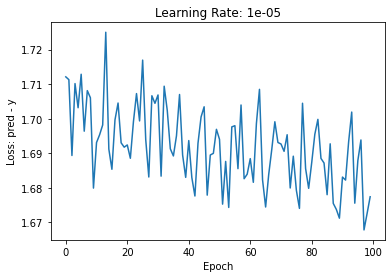

Learning rate 0.01: 0.6713324745956777


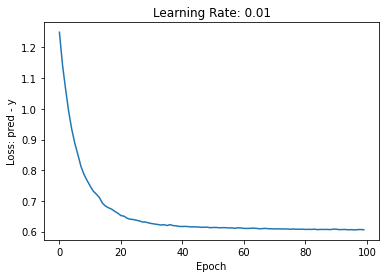

Learning rate 0.03: 0.6733934449692286


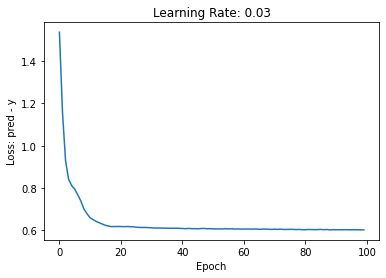

In [ ]:
boohee_subset = boohee.sample(n=50000)
boohee_subet_nodes = pd.unique(boohee_subset[['from', 'to']].values.ravel('K')).tolist()
X_Sample = X.loc[boohee_subet_nodes]
Y_Sample = Y.loc[boohee_subet_nodes]

G_Boohee = nx.from_pandas_edgelist(boohee_subset, 'from', 'to')
print("Step 1: Adding Edges into Boohee Network Completed")

X_Attributes_dict = dict(zip(X_Sample.index, X_Sample.to_numpy())) # CORRECT! RETURNS x=[27, 8] # of nodes and # of features
Y_dict = dict(zip(Y_Sample.index, Y_Sample['weight_loss_status'].values.tolist())) # WRONG! RETURNS y=[27, 1]. Should be y=[27]

nx.set_node_attributes(G_Boohee, X_Attributes_dict, "x")
nx.set_node_attributes(G_Boohee, Y_dict, "y")

boohee_PYG = from_networkx(G_Boohee)

print("Step 2: Convert networkx dataset to PyTorch Dataset Comnpleted")

train_mask, val_mask, test_mask = torch.utils.data.random_split(boohee_PYG.y, [0.8, 0.1, 0.1])
print("Step 3: Split into train_mask, val_mask, and test_mask Completed")


# 2 Convolutional Network
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(boohee_PYG.num_node_features, 16)
        self.conv2 = GCNConv(16, 2)

    def forward(self, data):
        x, edge_index = data.x.float(), data.edge_index
        x = Torch_F.relu(self.conv1(x, edge_index))
        x = Torch_F.dropout(x, training=self.training)
        x = self.conv2(x,edge_index)
        return Torch_F.log_softmax(x, dim=1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lr_param = [1e-5, 1e-2, 3e-2]
data = boohee_PYG.to(device)

while lr_param:
    learning_rate = lr_param.pop(0)
    accuracy_list = []
    for i in range(5):
        model = GCN().to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = 1e-4)
        model.train()
        losses = []
        for epoch in range(100):
            optimizer.zero_grad()
            out = model(data)
            loss = Torch_F.cross_entropy(out[train_mask.indices], data.y[train_mask.indices])
            losses.append(loss.item())
            loss.backward()
            optimizer.step()

        model.eval()
        pred = model(data).argmax(dim=1)
        correct = (pred[test_mask.indices] == data.y[test_mask.indices]).sum()
        acc = int(correct) / len(test_mask.indices)
        accuracy_list.append(acc)
    print('Learning rate ' + str(learning_rate) + ': ' + str(statistics.mean(accuracy_list)))

    x = range(100)
    plt.plot(x, losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss: pred - y')
    plt.title('Learning Rate: ' + str(learning_rate))
    plt.show()


Step 1: Adding Edges into Boohee Network Completed
Step 2: Convert networkx dataset to PyTorch Dataset Comnpleted
Step 3: Split into train_mask, val_mask, and test_mask Completed
Weight decay 0.0001: 0.6717552887364208


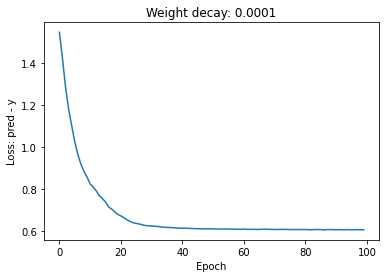

Weight decay 0.001: 0.6700400228702116


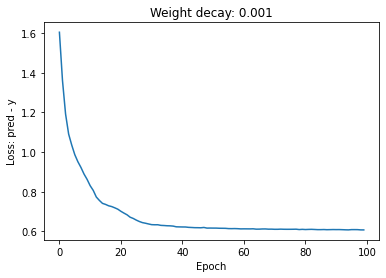

Weight decay 0.01: 0.6699256718124642


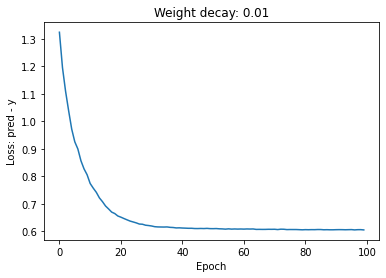

Weight decay 0.1: 0.6650371640937679


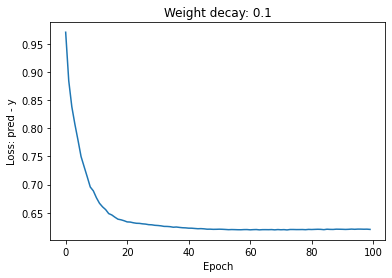

In [ ]:
boohee_subset = boohee.sample(n=50000)
boohee_subet_nodes = pd.unique(boohee_subset[['from', 'to']].values.ravel('K')).tolist()
X_Sample = X.loc[boohee_subet_nodes]
Y_Sample = Y.loc[boohee_subet_nodes]

G_Boohee = nx.from_pandas_edgelist(boohee_subset, 'from', 'to')
print("Step 1: Adding Edges into Boohee Network Completed")

X_Attributes_dict = dict(zip(X_Sample.index, X_Sample.to_numpy())) # CORRECT! RETURNS x=[27, 8] # of nodes and # of features
Y_dict = dict(zip(Y_Sample.index, Y_Sample['weight_loss_status'].values.tolist()))

nx.set_node_attributes(G_Boohee, X_Attributes_dict, "x")
nx.set_node_attributes(G_Boohee, Y_dict, "y")

boohee_PYG = from_networkx(G_Boohee)

print("Step 2: Convert networkx dataset to PyTorch Dataset Comnpleted")

train_mask, val_mask, test_mask = torch.utils.data.random_split(boohee_PYG.y, [0.8, 0.1, 0.1])
print("Step 3: Split into train_mask, val_mask, and test_mask Completed")


# 2 Convolutional Network
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(boohee_PYG.num_node_features, 16)
        self.conv2 = GCNConv(16, 2)

    def forward(self, data):
        x, edge_index = data.x.float(), data.edge_index
        x = Torch_F.relu(self.conv1(x, edge_index))
        x = Torch_F.dropout(x, training=self.training)
        x = self.conv2(x,edge_index)
        return Torch_F.log_softmax(x, dim=1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
weight_decay_param = [1e-4, 1e-3, 1e-2, 1e-1]
data = boohee_PYG.to(device)

while weight_decay_param:
    wd = weight_decay_param.pop(0)
    accuracy_list = []
    for i in range(5):
        model = GCN().to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay = wd)
        model.train()
        losses = []
        for epoch in range(100):
            optimizer.zero_grad()
            out = model(data)
            loss = Torch_F.cross_entropy(out[train_mask.indices], data.y[train_mask.indices])
            losses.append(loss.item())
            loss.backward()
            optimizer.step()

        model.eval()
        pred = model(data).argmax(dim=1)
        correct = (pred[test_mask.indices] == data.y[test_mask.indices]).sum()
        acc = int(correct) / len(test_mask.indices)
        accuracy_list.append(acc)
    print('Weight decay ' + str(wd) + ': ' + str(statistics.mean(accuracy_list)))


    x = range(100)
    plt.plot(x, losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss: pred - y')
    plt.title('Weight decay: ' + str(wd))
    plt.show()


Step 1: Adding Edges into Boohee Network Completed
Step 2: Convert networkx dataset to PyTorch Dataset Comnpleted
Step 3: Split into train_mask, val_mask, and test_mask Completed
Step 1: Adding Edges into Boohee Network Completed
Step 2: Convert networkx dataset to PyTorch Dataset Comnpleted
Step 3: Split into train_mask, val_mask, and test_mask Completed
Step 1: Adding Edges into Boohee Network Completed
Step 2: Convert networkx dataset to PyTorch Dataset Comnpleted
Step 3: Split into train_mask, val_mask, and test_mask Completed
Step 1: Adding Edges into Boohee Network Completed
Step 2: Convert networkx dataset to PyTorch Dataset Comnpleted
Step 3: Split into train_mask, val_mask, and test_mask Completed
Step 1: Adding Edges into Boohee Network Completed
Step 2: Convert networkx dataset to PyTorch Dataset Comnpleted
Step 3: Split into train_mask, val_mask, and test_mask Completed
Step 1: Adding Edges into Boohee Network Completed
Step 2: Convert networkx dataset to PyTorch Dataset Co

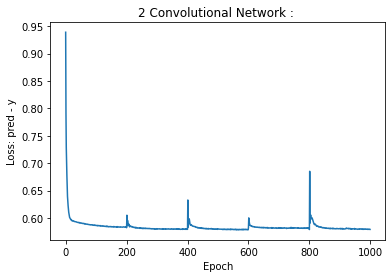

In [ ]:
#Experiment on 2 layer GCN

boohee_subset = boohee.sample(n=100)
boohee_subet_nodes = pd.unique(boohee_subset[['from', 'to']].values.ravel('K')).tolist()
X_Sample = X.loc[boohee_subet_nodes]
Y_Sample = Y.loc[boohee_subet_nodes]

G_Boohee = nx.from_pandas_edgelist(boohee_subset, 'from', 'to')
print("Step 1: Adding Edges into Boohee Network Completed")

X_Attributes_dict = dict(zip(X_Sample.index, X_Sample.to_numpy())) # CORRECT! RETURNS x=[27, 8] # of nodes and # of features
Y_dict = dict(zip(Y_Sample.index, Y_Sample['weight_loss_status'].values.tolist()))

nx.set_node_attributes(G_Boohee, X_Attributes_dict, "x")
nx.set_node_attributes(G_Boohee, Y_dict, "y")

boohee_PYG = from_networkx(G_Boohee)

print("Step 2: Convert networkx dataset to PyTorch Dataset Comnpleted")

train_mask, val_mask, test_mask = torch.utils.data.random_split(boohee_PYG.y, [0.8, 0.1, 0.1])
print("Step 3: Split into train_mask, val_mask, and test_mask Completed")

# 2 Convolutional Network
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(boohee_PYG.num_node_features, 16)
        self.conv2 = GCNConv(16, 2)

    def forward(self, data):
        x, edge_index = data.x.float(), data.edge_index
        x = Torch_F.relu(self.conv1(x, edge_index))
        x = Torch_F.dropout(x, training=self.training)
        x = self.conv2(x,edge_index)
        return Torch_F.log_softmax(x, dim=1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = boohee_PYG.to(device)
model = GCN().to(device)

accuracy_list = []
losses = []

for i in range(5):
    boohee_subset = boohee.sample(n=200000)
    boohee_subet_nodes = pd.unique(boohee_subset[['from', 'to']].values.ravel('K')).tolist()
    X_Sample = X.loc[boohee_subet_nodes]
    Y_Sample = Y.loc[boohee_subet_nodes]

    G_Boohee = nx.from_pandas_edgelist(boohee_subset, 'from', 'to')
    print("Step 1: Adding Edges into Boohee Network Completed")

    X_Attributes_dict = dict(zip(X_Sample.index, X_Sample.to_numpy())) # CORRECT! RETURNS x=[27, 8] # of nodes and # of features
    Y_dict = dict(zip(Y_Sample.index, Y_Sample['weight_loss_status'].values.tolist()))

    nx.set_node_attributes(G_Boohee, X_Attributes_dict, "x")
    nx.set_node_attributes(G_Boohee, Y_dict, "y")

    boohee_PYG = from_networkx(G_Boohee)

    print("Step 2: Convert networkx dataset to PyTorch Dataset Comnpleted")

    train_mask, val_mask, test_mask = torch.utils.data.random_split(boohee_PYG.y, [0.8, 0.1, 0.1])
    print("Step 3: Split into train_mask, val_mask, and test_mask Completed")
    data = boohee_PYG.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.03, weight_decay = 1e-4)
    model.train()
    for epoch in range(200):
        optimizer.zero_grad()
        out = model(data)
        loss = Torch_F.cross_entropy(out[train_mask.indices], data.y[train_mask.indices])
        losses.append(loss.item())
        loss.backward()
        optimizer.step()

    model.eval()
    pred = model(data).argmax(dim=1)
    correct = (pred[test_mask.indices] == data.y[test_mask.indices]).sum()
    acc = int(correct) / len(test_mask.indices)
    accuracy_list.append(acc)

print(accuracy_list)
print('2 layer Accuracy: ' + str(statistics.mean(accuracy_list)))
x = range(1000)
plt.plot(x, losses)
plt.xlabel('Epoch')
plt.ylabel('Loss: pred - y')
plt.title('2 Convolutional Network : ')
plt.show()


Step 1: Adding Edges into Boohee Network Completed
Step 2: Convert networkx dataset to PyTorch Dataset Comnpleted
Step 3: Split into train_mask, val_mask, and test_mask Completed
Step 1: Adding Edges into Boohee Network Completed
Step 2: Convert networkx dataset to PyTorch Dataset Comnpleted
Step 3: Split into train_mask, val_mask, and test_mask Completed
Step 1: Adding Edges into Boohee Network Completed
Step 2: Convert networkx dataset to PyTorch Dataset Comnpleted
Step 3: Split into train_mask, val_mask, and test_mask Completed
Step 1: Adding Edges into Boohee Network Completed
Step 2: Convert networkx dataset to PyTorch Dataset Comnpleted
Step 3: Split into train_mask, val_mask, and test_mask Completed
Step 1: Adding Edges into Boohee Network Completed
Step 2: Convert networkx dataset to PyTorch Dataset Comnpleted
Step 3: Split into train_mask, val_mask, and test_mask Completed
Step 1: Adding Edges into Boohee Network Completed
Step 2: Convert networkx dataset to PyTorch Dataset Co

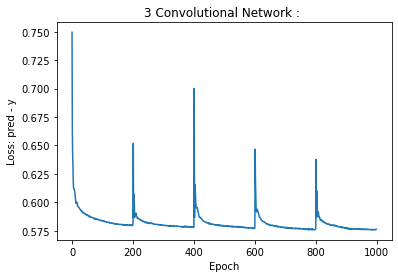

In [ ]:
#Experiment on 3 layer GCN

boohee_subset = boohee.sample(n=100)
boohee_subet_nodes = pd.unique(boohee_subset[['from', 'to']].values.ravel('K')).tolist()
X_Sample = X.loc[boohee_subet_nodes]
Y_Sample = Y.loc[boohee_subet_nodes]

G_Boohee = nx.from_pandas_edgelist(boohee_subset, 'from', 'to')
print("Step 1: Adding Edges into Boohee Network Completed")

X_Attributes_dict = dict(zip(X_Sample.index, X_Sample.to_numpy())) # CORRECT! RETURNS x=[27, 8] # of nodes and # of features
Y_dict = dict(zip(Y_Sample.index, Y_Sample['weight_loss_status'].values.tolist()))

nx.set_node_attributes(G_Boohee, X_Attributes_dict, "x")
nx.set_node_attributes(G_Boohee, Y_dict, "y")

boohee_PYG = from_networkx(G_Boohee)

print("Step 2: Convert networkx dataset to PyTorch Dataset Comnpleted")

train_mask, val_mask, test_mask = torch.utils.data.random_split(boohee_PYG.y, [0.8, 0.1, 0.1])
print("Step 3: Split into train_mask, val_mask, and test_mask Completed")

# 3 Convolutional Network
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(boohee_PYG.num_node_features, 16)
        self.conv2 = GCNConv(16, 16)
        self.conv3 = GCNConv(16, 2)

    def forward(self, data):
        x, edge_index = data.x.float(), data.edge_index
        x = Torch_F.relu(self.conv1(x, edge_index))
        x = Torch_F.dropout(x, training=self.training)
        x = Torch_F.relu(self.conv2(x,edge_index))
        x = self.conv3(x,edge_index)
        return Torch_F.log_softmax(x, dim=1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = boohee_PYG.to(device)

accuracy_list = []
losses = []

model = GCN().to(device)

for i in range(5):
    boohee_subset = boohee.sample(n=200000)
    boohee_subet_nodes = pd.unique(boohee_subset[['from', 'to']].values.ravel('K')).tolist()
    X_Sample = X.loc[boohee_subet_nodes]
    Y_Sample = Y.loc[boohee_subet_nodes]

    G_Boohee = nx.from_pandas_edgelist(boohee_subset, 'from', 'to')
    print("Step 1: Adding Edges into Boohee Network Completed")

    X_Attributes_dict = dict(zip(X_Sample.index, X_Sample.to_numpy())) # CORRECT! RETURNS x=[27, 8] # of nodes and # of features
    Y_dict = dict(zip(Y_Sample.index, Y_Sample['weight_loss_status'].values.tolist()))

    nx.set_node_attributes(G_Boohee, X_Attributes_dict, "x")
    nx.set_node_attributes(G_Boohee, Y_dict, "y")

    boohee_PYG = from_networkx(G_Boohee)

    print("Step 2: Convert networkx dataset to PyTorch Dataset Comnpleted")

    train_mask, val_mask, test_mask = torch.utils.data.random_split(boohee_PYG.y, [0.8, 0.1, 0.1])
    print("Step 3: Split into train_mask, val_mask, and test_mask Completed")
    data = boohee_PYG.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.03, weight_decay = 1e-4)
    model.train()
    for epoch in range(200):
        optimizer.zero_grad()
        out = model(data)
        loss = Torch_F.cross_entropy(out[train_mask.indices], data.y[train_mask.indices])
        losses.append(loss.item())
        loss.backward()
        optimizer.step()

    model.eval()
    pred = model(data).argmax(dim=1)
    correct = (pred[test_mask.indices] == data.y[test_mask.indices]).sum()
    acc = int(correct) / len(test_mask.indices)
    accuracy_list.append(acc)

print(accuracy_list)
print('3 layer Accuracy: ' + str(statistics.mean(accuracy_list)))
x = range(1000)
plt.plot(x, losses)
plt.xlabel('Epoch')
plt.ylabel('Loss: pred - y')
plt.title('3 Convolutional Network : ')
plt.show()


Step 1: Adding Edges into Boohee Network Completed
Step 2: Convert networkx dataset to PyTorch Dataset Comnpleted
Step 3: Split into train_mask, val_mask, and test_mask Completed
Step 1: Adding Edges into Boohee Network Completed
Step 2: Convert networkx dataset to PyTorch Dataset Comnpleted
Step 3: Split into train_mask, val_mask, and test_mask Completed
Step 1: Adding Edges into Boohee Network Completed
Step 2: Convert networkx dataset to PyTorch Dataset Comnpleted
Step 3: Split into train_mask, val_mask, and test_mask Completed
Step 1: Adding Edges into Boohee Network Completed
Step 2: Convert networkx dataset to PyTorch Dataset Comnpleted
Step 3: Split into train_mask, val_mask, and test_mask Completed
Step 1: Adding Edges into Boohee Network Completed
Step 2: Convert networkx dataset to PyTorch Dataset Comnpleted
Step 3: Split into train_mask, val_mask, and test_mask Completed
Step 1: Adding Edges into Boohee Network Completed
Step 2: Convert networkx dataset to PyTorch Dataset Co

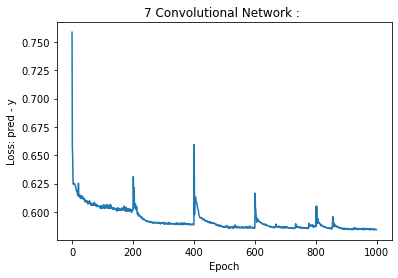

In [ ]:
#Experiment on 7 layer GCN

boohee_subset = boohee.sample(n=100)
boohee_subet_nodes = pd.unique(boohee_subset[['from', 'to']].values.ravel('K')).tolist()
X_Sample = X.loc[boohee_subet_nodes]
Y_Sample = Y.loc[boohee_subet_nodes]

G_Boohee = nx.from_pandas_edgelist(boohee_subset, 'from', 'to')
print("Step 1: Adding Edges into Boohee Network Completed")

X_Attributes_dict = dict(zip(X_Sample.index, X_Sample.to_numpy())) # CORRECT! RETURNS x=[27, 8] # of nodes and # of features
Y_dict = dict(zip(Y_Sample.index, Y_Sample['weight_loss_status'].values.tolist()))

nx.set_node_attributes(G_Boohee, X_Attributes_dict, "x")
nx.set_node_attributes(G_Boohee, Y_dict, "y")

boohee_PYG = from_networkx(G_Boohee)

print("Step 2: Convert networkx dataset to PyTorch Dataset Comnpleted")

train_mask, val_mask, test_mask = torch.utils.data.random_split(boohee_PYG.y, [0.8, 0.1, 0.1])
print("Step 3: Split into train_mask, val_mask, and test_mask Completed")

# 5 Convolutional Network
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(boohee_PYG.num_node_features, 16)
        self.conv2 = GCNConv(16, 16)
        self.conv3 = GCNConv(16, 16)
        self.conv4 = GCNConv(16, 16)
        self.conv5 = GCNConv(16, 16)
        self.conv6 = GCNConv(16, 16)
        self.conv7 = GCNConv(16, 2)

    def forward(self, data):
        x, edge_index = data.x.float(), data.edge_index
        x = Torch_F.relu(self.conv1(x, edge_index))
        x = Torch_F.dropout(x, training=self.training)
        x = Torch_F.relu(self.conv2(x, edge_index))
        x = Torch_F.dropout(x, training=self.training)
        x = Torch_F.relu(self.conv3(x, edge_index))
        x = Torch_F.dropout(x, training=self.training)
        x = Torch_F.relu(self.conv4(x, edge_index))
        x = Torch_F.dropout(x, training=self.training)
        x = Torch_F.relu(self.conv5(x, edge_index))
        x = Torch_F.dropout(x, training=self.training)
        x = Torch_F.relu(self.conv6(x, edge_index))
        x = Torch_F.dropout(x, training=self.training)
        x = self.conv7(x,edge_index)
        return Torch_F.log_softmax(x, dim=1)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = boohee_PYG.to(device)
model = GCN().to(device)
accuracy_list = []
losses = []


for i in range(5):
    boohee_subset = boohee.sample(n=200000)
    boohee_subet_nodes = pd.unique(boohee_subset[['from', 'to']].values.ravel('K')).tolist()
    X_Sample = X.loc[boohee_subet_nodes]
    Y_Sample = Y.loc[boohee_subet_nodes]

    G_Boohee = nx.from_pandas_edgelist(boohee_subset, 'from', 'to')
    print("Step 1: Adding Edges into Boohee Network Completed")

    X_Attributes_dict = dict(zip(X_Sample.index, X_Sample.to_numpy())) # CORRECT! RETURNS x=[27, 8] # of nodes and # of features
    Y_dict = dict(zip(Y_Sample.index, Y_Sample['weight_loss_status'].values.tolist()))

    nx.set_node_attributes(G_Boohee, X_Attributes_dict, "x")
    nx.set_node_attributes(G_Boohee, Y_dict, "y")

    boohee_PYG = from_networkx(G_Boohee)

    print("Step 2: Convert networkx dataset to PyTorch Dataset Comnpleted")

    train_mask, val_mask, test_mask = torch.utils.data.random_split(boohee_PYG.y, [0.8, 0.1, 0.1])
    print("Step 3: Split into train_mask, val_mask, and test_mask Completed")

    data = boohee_PYG.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.03, weight_decay = 1e-4)
    model.train()
    for epoch in range(200):
        optimizer.zero_grad()
        out = model(data)
        loss = Torch_F.cross_entropy(out[train_mask.indices], data.y[train_mask.indices])
        losses.append(loss.item())
        loss.backward()
        optimizer.step()

    model.eval()
    pred = model(data).argmax(dim=1)
    correct = (pred[test_mask.indices] == data.y[test_mask.indices]).sum()
    acc = int(correct) / len(test_mask.indices)
    accuracy_list.append(acc)

print(accuracy_list)
print('7 layer Accuracy: ' + str(statistics.mean(accuracy_list)))
x = range(1000)
plt.plot(x, losses)
plt.xlabel('Epoch')
plt.ylabel('Loss: pred - y')
plt.title('7 Convolutional Network : ')
plt.show()


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_Sample, Y_Sample, test_size=0.2, random_state=42)

clf = LogisticRegression(random_state=0).fit(X_train, np.ravel(y_train))
score = clf.score(X_test, np.ravel(y_test))
print(score)

0.7077184414481368
